Niklas E. Siedhoff<sup><em>1,§</em></sup>, Alexander-Maurice Illig<sup><em>1,§</em></sup>, Ulrich Schwaneberg<sup><em>1,2</em></sup>, Mehdi D. Davari<sup><em>1,*</em></sup>, <br>
PyPEF – an Integrated Framework for Data-driven Protein Engineering, <em>Journal of Chemical Information and Modeling</em> (2021) <br>
<sup><em>1</em></sup><sub>Institute of Biotechnology, RWTH Aachen University, Worringer Weg 3, 52074 Aachen, Germany</sub> <br>
<sup><em>2</em></sup><sub>DWI-Leibniz Institute for Interactive Materials, Forckenbeckstraße 50, 52074 Aachen, Germany</sub> <br>
<sup><em>*</em></sup><sub>Corresponding author</sub> <br>
<sup><em>§</em></sup><sub>Equal contribution</sub> <br>

### Machine learning-assisted protein engineering framework "PyPEF" 
PyPEF 0.2.4, May 2023
#### by Niklas Siedhoff and Alexander-Maurice Illig

## General Description

In the following, the reported version of the machine learning framework PyPEF is presented. The tool is written in Python 3 and inteded for executing in a command-line interpreter or **for running inside this Notebook, see [Running in Terminal](#Running-in-Terminal)**. A general workflow of this tool is presented and described hereinafter (see Figure 1).

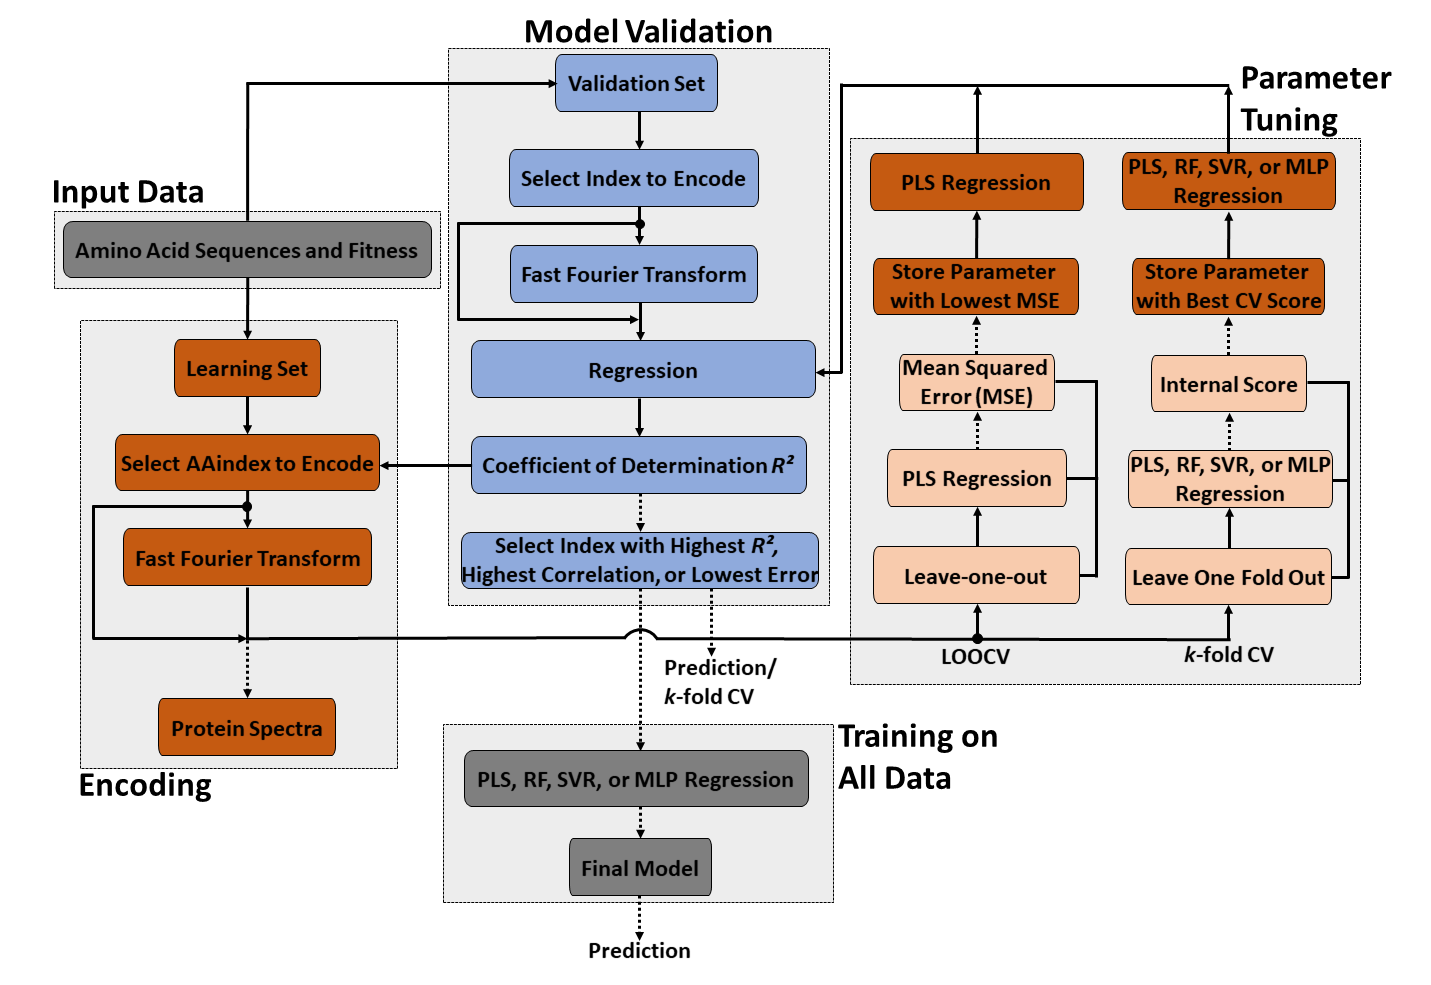

**Figure 1:** Schematic overview of the regression-based algorithm PyPEF: Gray components refer to the whole dataset size, blue to the test dataset used for model generalization validation and orange to the learning dataset. Light orange refers to the process of leave-one-out (LOOCV) or $k$-fold CV at which the learning dataset size is reduced by 1 or 1-fold, respectively. Additionally implemented (CV-tuned) options for regression are listed below. <sup>Adopted Figure, Original Figure (C) ACS – Journal of Chemical Information and Modeling<sup/>  

PyPEF uses some regressors provided by the [scikit-learn](https://scikit-learn.org/stable/index.html) package. Tuning is performed either using the approach of [Cadet *et al.*](https://www.nature.com/articles/s41598-018-35033-y) (leave-one-out cross validation and mean-squared error calculation for *N* component tuning) for PLS regression or else using a defined parameter grid and the [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) module and 5-fold cross-validation. 
PyPEF contains following encoding and regression options that can be defined by user arguments:
- Fourier transform of encoded sequences [default; optional: --nofft]
- Training/tuning of [PLS regressor](https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html) as proposed by Cadet et al. (LOOCV and MSE calculation) [default; --regressor pls_loocv]
- Training/tuning of PLS regressor using GridSearchCV (faster and thus new default) [--regressor pls]
- Training/tuning of [Random Forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) using GridSearchCV [--regressor rf]
- Training/tuning of [Support Vector Machines regressor](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) using GridSearchCV [--regressor svr]
- Training/tuning of [multilayer perceptron (MLP) regressor](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html) (a deep learning model with feedforward deep network trained via backpropagation) using GridSearchCV [--regressor mlp]
- Training/tuning of [Ridge regressor (L2 regularized)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) using GridSearchCV [--regressor ridge]
- Training/tuning of [Lasso regressor (L1 regularized)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoLars.html) using GridSearchCV [--regressor lassolars]
- Training/tuning of [ElasticNet regressor (L1 and L2 regularized)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) using GridSearchCV [--regressor lassolars]

The developed algorithm encompasses the automatized transformation of the given input sequences into numerical values using AAindex databank entries, default Fourier transform of the numerical sequences to protein spectra, (k-fold or leave-one-out) cross-validation for selecting the best model hyperparmeter, and consequently estimating model performance on a validation dataset. Besides, the model can also be generated without using FFT for processing of the sequence encoding.
Finally, the trained machine is used for estimating the fitness value of every given variant of length $N$, $N$ being the number of variant amino acids, in the unknown sequence space. The first step of the algorithm signifies the transformation of the given input sequences into numerical values. This conversion is performed for all entries of the AAindex database with the minimum availability of all 20 naturally encoded amino acids (a list of all 566 indices can be obtained from https://www.genome.jp/aaindex/AAindex/list_of_indices), so that the matrix $\mathbf{F} \in \mathbb{R}^{1 \times N}$ is established with $x_n$ being the value of the $n$-th entry:

$$ \mathbf{F} = \left(\begin{matrix} x_{0} & x_{1} & \dots & x_{N_{\mathrm{seq}-1}} \end{matrix}\right) $$

Each of the $N$ values is then normalized ($\tilde{x}$) following

$$ \tilde{x}_n = x_{n} - \overline{x} \ ,$$ 

with

$$ \overline{x} = \frac{1}{N} \sum_{n=0}^N x_n \ ,$$

so that artifacts of the Fourier transform can be avoided. The implemented fast Fourier transform (FFT) algorithm constraines $\mathbf{F} \in \mathbb{R}^{1 \times N_\mathrm{Dim}}$ to the condition

$$ N_\mathrm{Dim}\overset{!}{=}2^k, k \in \mathbb{N} \ .$$


If $N$ does not hold for the upper equation, $\mathbf{F}$ is reshaped by adding columns of zeros ("zero padding") until the condition is fulfilled. This normalized (and zero padded) matrix ($\mathbf{\tilde{F}}$) is then FFT-ed following

$$ \left|\hat{F}_j\right| = \left|\sum_{n=0}^{N_{\mathrm{Dim}}-1} \tilde{x}_{n} \exp \left( -\frac{2 \pi i j n}{N_{\mathrm{Dim}}} \right) \right| \ , \hat{F}_j \in \mathbb{C} \ , $$

with spectrum frequencies $j \in [0, 1, …, N_{\mathrm{Dim}}–1]$ and the imaginary number $i^2 = \, – 1$. A following plot of a normalized protein spectrum is presented in Figure 2. Since $\hat{F}_{N-j} = (\hat{F}_j)^*$, the FFT spectrum is mirrored at $0.5 \, j_{\mathrm{max}}$, as a result there is no need to use all frequencies for learning to obtain the saturated information content.

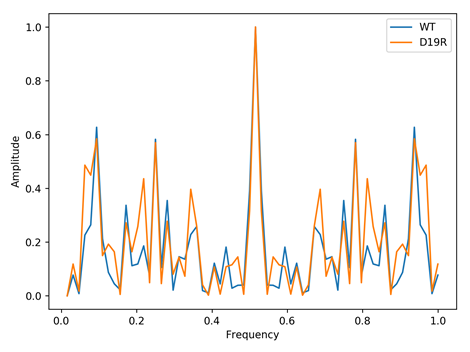

**Figure 2:** FFT protein spectra (of the peptide liquid chromatography peak I, LCI, wild-type (blue) and variant D19R (orange)). 

The spectrum amplitudes represent the independent variables and are used as input for the PLS regressor. $y$ is usually expressed as variant's (V) relative fitness value normalized to the wild-type (WT), i.e. $y = \frac{y_\mathrm{Variant}}{y_\mathrm{Wild-type}}$. The PLS regressor is fed with all except one input variant spectra when performing LOOCV parameter omptimization; else, regressors are trained on all data except the validation fold. Then, the trained regression model is used for predicting the label of the left-out variant(s). For $m$ given input sequences as learning dataset this process is performed  $\binom{m}{1} = m$ times for LOOCV and when using `GridSearchCV(cv=k)` $k$ times. For PLS regression (else GridSearchCV is used for tuning), for all predictions ($y$) of $y_\mathrm{true}$ building up the vector of the length $m$, the MSE is calculated following:

$$ \mathrm{MSE} =  \frac{1}{m} \sum_{i=1}^{m} (y_{\mathrm{obs},i} - y_{\mathrm{pred},i})^2 \ .$$   
    
The model hyperparameter ‘n_components’, the number of components in the PLS regression, is increased by 1 after every MSE loop up to ‘n_components’ reaching 10. An exemplary plot for the iteration of the number of components is shown in Figure 3. Here, the final model for the taken AAindex would be trained using 4 as the number of components for PLS regression.
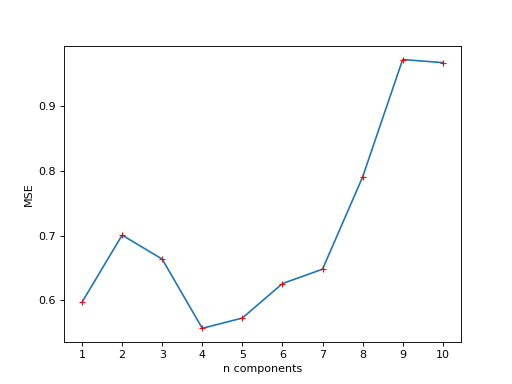

**Figure 3:** Exemplary plot of the mean-squared error for the iteration over the number of components for PLS regression.

For more information about estimating the number of components in PLS regression and the trade-off of overfitting and good predictions see other articles, e.g. <a href="https://www.sciencedirect.com/science/article/pii/0003267086800289" target="_blank">Link-1</a> and <a href="https://arxiv.org/pdf/1810.08104.pdf" target="_blank">Link-2</a>. For every AAindex, the model with the lowest MSE<sub>LOOCV</sub> is stored. The best performing numbers of components are used for training the 566 PLS regressors on the whole learning dataset (one variant more than in the LOOCV training dataset) and predicting the label of a given yet unseen validation dataset. For GridSearchCV parameter tuning, the scoring function of the used estimator, i.e. the `score` [method](https://scikit-learn.org/stable/modules/model_evaluation.html) of the regression type is used. The performance of these predictions are determined by calculating the $R^2$ score and prediction errors (RMSE, normalized RMSE (NRMSE)), as well as correlation (Pearson's $r$ and Spearman's rank correlation $\rho$) of the predicted observations ($y_\mathrm{pred}$) and the measured fitness values ($y_\mathrm{obs}$) following

$$ R^2 = \frac{\sum_{i=1}^{N} ({y_{\mathrm{pred},i} - \overline{y}_{\mathrm{obs}})^2}}{\sum_{i=1}^{N} ({y_{\mathrm{obs},i} - \overline{y}_{\mathrm{obs}}})^2} \ ,$$ 
and 
$$ RMSE = \sqrt{MSE} = \sqrt{\frac{1}{N} \sum_{i=1}^{N} (y_{\mathrm{obs},i} - y_{\mathrm{pred},i})^2} \ ,$$ 
while we defined the normalized RMSE (NRMSE) as normalized taking the sample standard deviation ($\sigma$) for division 
$$ NRMSE = \frac{RMSE}{\sigma} \ ,$$
with $$ \sigma = \sqrt{\frac{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}{N-1}} \ ,$$
respectively,
and the Pearson corellation coefficient $r$ being defined as
$$ r_\mathrm{Y_\mathrm{obs}, Y_\mathrm{pred}} = \frac{cov(Y_\mathrm{obs}, Y_\mathrm{pred})}{{\sigma_Y}_\mathrm{obs}{\sigma_Y}_\mathrm{pred}}
= \frac{\sum_{i=1}^{N}{(y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs})(y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred})}}
{\sqrt{\sum_{i=1}^{N}({y_{\mathrm{obs},i} - \overline{y}_\mathrm{obs}})^2}
\sqrt{\sum_{i=1}^{N}({y_{\mathrm{pred},i} - \overline{y}_\mathrm{pred}})^2}}
 \ ,$$
while we also implemented the study of rank corellation performance computing the Spearman rank correlation $\rho$
being the Pearson correlation coefficient between the fitness ranks (instead of raw values),
where $N$ defines the number of variants in the validation set.

Also other regression and encoding techniques, i.e. one-hot and DCA-based, are implemented which are not described here. For the other encoding methods, FFT of the encoded sequences is not provided as further processing option.

The user specifies a threshold for the number of saving the *n* best models according to the $R^2$ score on the validation dataset (also see [Cadet *et al.*](https://www.nature.com/articles/s41598-018-35033-y)). These *s* best models will be dumped as [pickle](https://docs.python.org/3/library/pickle.html) files and can easily be reloaded for predictions on new variants sequence space later on. After validation and optional viszualization of the measured and predicted observations (see Figure 4), the final model can optionally be trained on the whole dataset. An exemplary plot of a validation routine is shown hereinafter.

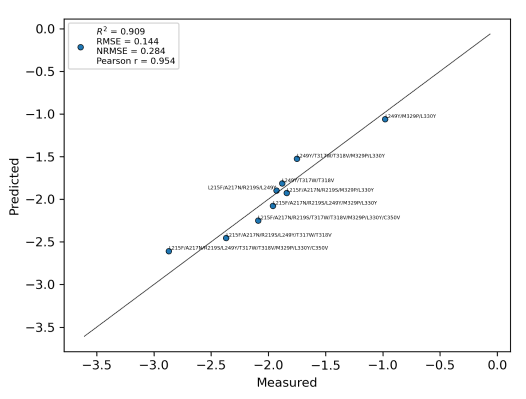

**Figure 4:** Validaton plot of predicted vs. measured entries of the test dataset used for final model validation.

##### Performing predictions

Predictions using trained models can be performed on pure recombinant or natural diverse sequence data. However, as the sequence space to screen drastically increases for the number of simultaneously added mutation sites, we added the possiblity to explore the unknown variant space performing a random walk on diverse *in silico* directed evolution paths as described and presented by [Biswal *et al.*](https://www.biorxiv.org/content/10.1101/2020.01.23.917682v2); the corresponding code can be explored here: [GitHub repository](https://github.com/ivanjayapurna/low-n-protein-engineering) and exemplary [Jupyter Notebook](https://github.com/ivanjayapurna/low-n-protein-engineering/blob/master/directed-evo/DE_notebook.ipynb).

After randomly chosing and accepting a first mutation in a sequence, subsequently, substitutions will be added when meeting an update criterion that is defined by the Metropolis-Hastings algorithm. Here, the Metropolis choice for acception (when setting the Boltzmann constant $k$ to one) is defined as:
$$ A = min(1,exp(\frac{\Delta y_\mathrm{pred}}{T})) \ ,$$

with $T$ being the "Temperature" of the "Boltzmann-distributed" system and ($\Delta y_\mathrm{pred}$) being the difference ($y^*_\mathrm{pred} - y_\mathrm{pred}$) of the newly predicted ($^*$) sequence fitness and the fitness of the sequence variant predicted before, respectively.
If we plot $\Delta y_\mathrm{pred}$ against $exp(\frac{\Delta y_\mathrm{pred}}{T})$ we can see the influence of the Temperature on the acceptance ratio (see Figure 5).

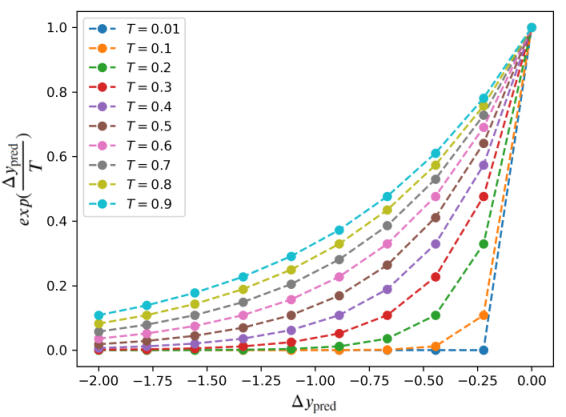

**Figure 5:** Influence of different temperatures on acceptance graph.

Then we randomly generate a number $u$ between 0 and 1 ($u \in [0,1]$). If $u \leq A$, the new state, that is the new sequence with $y^*_\mathrm{pred}$, gets accepted; else, i.e., if $u \gt A$, the new sequence will be rejected and the old will be kept. Instead of allowing more than a single substitution per iteration in evolution, we kept the number of introduced substitution per round at one.  

## Running in Terminal

Before running this protocol it is advised to create a new Python 3 environment, e.g. using [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). If you followed the README.md, you likely have already installed all required packages and running the requirements installation code fields can be skipped after changing the Kernel to 'pypef' (Kernel > Change Kernel > pypef). 
For this exemplary protocol we run our workflow on the ANEH set reported by [Gumulya, Sanchis, and Reetz]( https://doi.org/10.1002/cbic.201100784). For training, model testing, and predicting the relative energy ($\Delta\Delta G^{\neq}$) of the ANEH variants
the tool is run following a typical machine learning approach and comprises three steps:
***
1. Learning and model testing:<br>`python3 ./pypef/main.py ml -e aaidx -l Learning_Set.fasta -t Test_Set.fasta`
2. Visualization:<br> `python3 ./pypef/main.py ml -e aaidx -m MODEL12345 -f Test_Set.fasta`
3. Prediction:<br> `python3 ./pypef/main.py ml -e aaidx -m MODEL12345 -p Prediction_Set.fasta `
***
Alternative ways of implemented (likely superior techniques) for encoding are One-Hot (`-e onehot`) and DCA (`-e dca`).

## Exemplary running in Jupyter Notebook: Run code cells starting from here
We tested this Notebook running on [Python 3.9](https://www.python.org/downloads/). Starting with PyPEF 0.2.x, Python 3.9 or higher versions are required.
To ensure you are using the correct environment, i.e., Python version, you can activate your conda environment (here exemplary termed pypef) and load the ipython kernel.

`conda activate pypef`

`python3 -m ipykernel install --user`

Your current working directory should be inside the *workflow* folder at this point.
(Also you can run this cell later on to ensure that you are in the correct directory, followed by changing directory to test_dataset). 

In [ ]:
# run this cell first to save the script directory; here your working directory should be the folder "path/to/workflow".
# if not, change directory, e.g. using %cd or os.chdir() or run this cell a second time:
# If you changed the current working dir, this will take you back to the workbook dir.
import os
if not 'workbook_dir' in globals():
    workbook_dir = os.getcwd()
print('Current Working Directory: ' + workbook_dir)
os.chdir(workbook_dir)  
if workbook_dir[-8:] != "workflow":
    try:
        os.chdir(os.getcwd().split("workflow",1)[0] + "workflow")
        print("You are here \"{}\", You should be in the workflow directory for\
        running the script when starting from here!").format(os.getcwd())
    except:
        print("You are here \"{}\", please change path to /workflow directory.".format(os.getcwd()))
else:
    print("You are in the correct directory for running the script when starting from here!")

Installing required Python modules using [pip](https://pypi.org/). If you don't want to change your current Python Environment, better create a new one (e.g. using conda) and run then run the cell below.

In [ ]:
# Install packages in the current Jupyter kernel using pip, you can get installed packages and
# Py version with >>>print(help('modules'))
# Uncomment line below if modules are not installed for this ipython-kernel:
# %run -m pip install --user -r ../requirements.txt

In [ ]:
# adding the path to /pypef source modules (setting PYTHONPATH)
import sys 
print(f'Append path {workbook_dir[:-9]} to the PYTHONPATH list.')
sys.path.append(workbook_dir[:-9])
print(f'PYTHONPATH list:\n{sys.path}')

In [ ]:
%run ../pypef/main.py --version

In [ ]:
%run ../pypef/main.py -h

Change directory to /test_dataset and create learning (LS) and test (TS) datasets:

In [ ]:
%cd test_dataset_aneh/

(Due to logging children, output is printed multiple times in the Jupyter Notebook.)

In [ ]:
%run ../../pypef/main.py mklsts -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta

### Pure ML modeling

For hybrid modeling, here we use a very small dataset fraction of the ANEH dataset (37 variants with associated (negative) fitness values). Next, you can run model training and validation on the test sets and save the best models (in this notebook only using a single CPU). For DCA-based encoding, downloading the plmc parameter file is necessary (uncomment cell below).

In [ ]:
#import urllib.request
#from hashlib import sha256
#url = 'https://github.com/niklases/PyPEF/raw/main/workflow/test_dataset_aneh/ANEH_72.6.params'
#urllib.request.urlretrieve(url, 'ANEH_72.6.params') # File size: 207 MB
#with open('ANEH_72.6.params', 'rb') as f:
#    sha256_hash = sha256(f.read()).hexdigest()
#    if not sha256_hash == 'd84bd2185f5882c3ef01ab99264e30111333b8adb05136b953f407b1b6dfbaf8':
#        raise SystemError("Hash of downloaded DCA parameter file not correct, terminating further running.")
#print('Successfully downloaded ANEH_72.6.params!')

In [ ]:
%run ../../pypef/main.py ml -e aaidx -l LS.fasl -t TS.fasl --regressor pls
#%run ../../pypef/main.py ml -e onehot -l LS.fasl -t TS.fasl --regressor pls
#%run ../../pypef/main.py ml -e dca -l LS.fasl -t TS.fasl --regressor pls --params ANEH_72.6.params

# if an error occurs during training try other regression options (--regressor)
# finally training the model on all data would be defined by: 
# %run ../../pypef/main.py ml -e aaidx -l LS.fasl -t TS.fasl --regressor pls --all

Here, by default PLS was used as regressor and the model was tuned performing fivefold-CV (less time intensive than LOOCV) and Fourier transform of the encoded sequences. You can define the regressor you want to use using the flag `--regressor {pls, pls_cv, rf, svr, mlp, ridge, lassolars, elasticnet}` (pls_cv, rf, svr, ridge, lassolars, elasticnet tuned with GridSearchCV) and the encoding when no FFT is desired using flag `--nofft` (likely `--nofft` better option when using RF and SVR). For the tutorial we stick to the PLS regressor.

##### <font color='red'>This 'parallel running' section will not work when running inside this notebook</font>

Ray (https://docs.ray.io/en/latest/index.html) is used parallel running and outside this notebook you can define the flag `--threads` and the number of threads to be used, e.g. `--threads 4`.

In [ ]:
# Will not work inside the Jupyter Notebook as the sys path is not known (would require relative imports of pypef modules)
# using 4 cores for running the command would be:
#%run ../../pypef/main.py ml -e aaidx -l LS.fasl -t TS.fasl --regressor pls --threads 4

##### <font color='red'>Section end</font>

The output of the test (of the entries in *Test_Set.fasta*) is written to *Model_Result.txt* and furthermore, the 5-fold CV performance for each of the `-s TRESHOLD` models is plotted and stored in the folder *CV_performance*. Obviously, the computed $R^2$ heavily depends on the positional information content of the splitted learning and validation datasets. Note that a high number of components for a model might be a sign of overfitting; here the testing of *k*-fold datasplits might be helpful as indicator of possible overfitting (see folder *CV_performance*).
The best models are reported in the *Model_Results.txt* file; we can also show the model results using 

In [ ]:
%run ../../pypef/main.py ml --show

Next, one can plot the prediction on the validation dataset; e.g. for validating the predictions of the best model, i.e. index FAUJ880104 having an $R^2$ = 0.909, an RMSE = 0.144, and a Spearman's $\rho$ = 0.95! However, this does not mean that the identified model is the best across different splits, a good idea is also to investigate the *k*-fold CV performance of all models (folder *CV_performance*). For visualization of predictions run command cell below and see the stored *.png* image.

In [ ]:
%run ../../pypef/main.py ml -e aaidx -m FAUJ880104 -f TS.fasl
#%run ../../pypef/main.py ml -e onehot -m ONEHOTMODEL -f TS.fasl
#%run ../../pypef/main.py ml -e dca -m DCAMODEL -f TS.fasl --params ANEH_72.6.params

Or, you can save a labeled plot which uses adjustText (https://github.com/Phlya/adjustText/wiki) which iteratively tries to adjust the labels of the variants (can take some time for close/crowded data points).

In [ ]:
%run ../../pypef/main.py ml -e aaidx -m FAUJ880104 -f TS.fasl --label
#%run ../../pypef/main.py ml -e onehot -m ONEHOTMODEL -f TS.fasl --label
#%run ../../pypef/main.py ml -e dca -m DCAMODEL -f TS.fasl --label --params ANEH_72.6.params

The saved images should look similar to these plots (left: unlabeled, right: labeled):

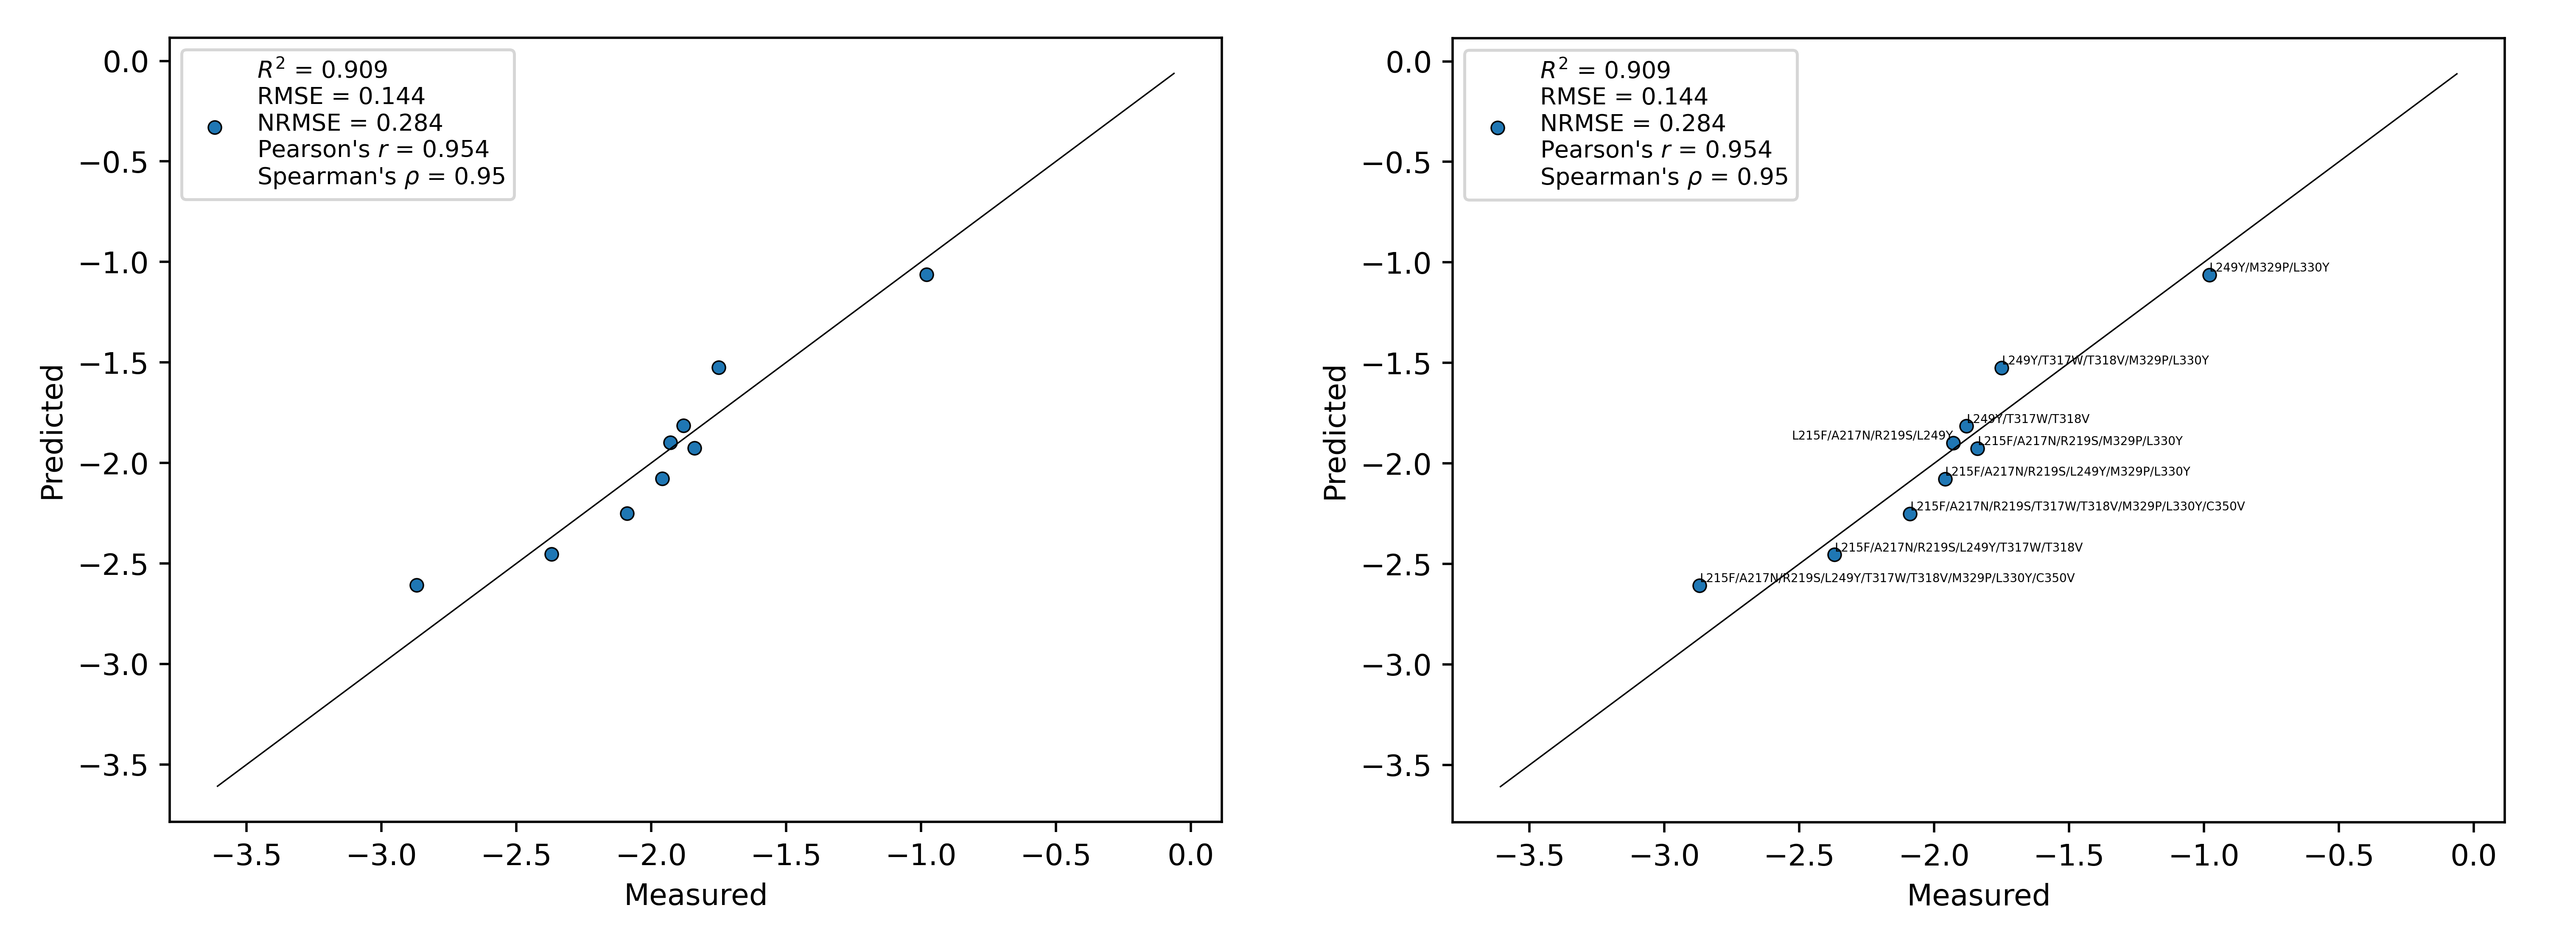

Or, to plot a colored version that divides the predicted variants in the classification categories false positive (FP, top left), true positive (TP, top right), true negative (TN, down left), false negative (FN, down right), try:

In [ ]:
%run ../../pypef/main.py ml -e aaidx -m FAUJ880104 -f TS.fasl --color --y_wt -1.5
#%run ../../pypef/main.py ml -e onehot -m ONEHOTMODEL -f TS.fasl --color --y_wt -1.5
#%run ../../pypef/main.py ml -e dca -m DCAMODEL -f TS.fasl --params ANEH_72.6.params --color --y_wt -1.5

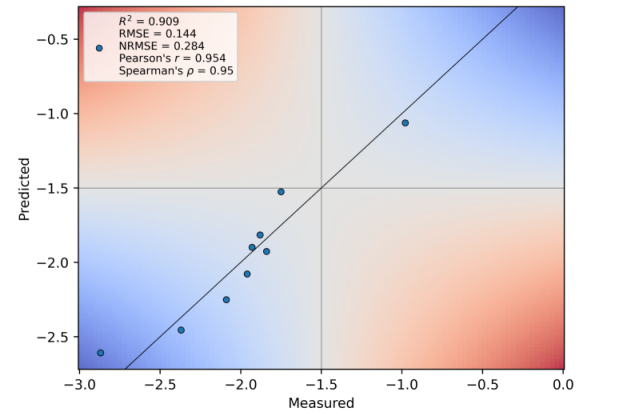

#### Making predictions
Finally, one can predict new variants of the unknown sequence space, e.g. by predicting double or triple substitutional variants with single substitutional recombinant (or full natural) diversity. For simplified prediction set generation one can use the `mkps` function.

In [ ]:
%run ../../pypef/main.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta

Predicting the prediction set entries:

In [ ]:
%run ../../pypef/main.py ml -e aaidx -m FAUJ880104 -p 37_ANEH_variants_prediction_set.fasta
#%run ../../pypef/main.py ml -e onehot -m ONEHOTMODEL -p 37_ANEH_variants_prediction_set.fasta
#%run ../../pypef/main.py ml -e dca -m DCAMODEL -p 37_ANEH_variants_prediction_set.fasta --params ANEH_72.6.params

Now we got an error as we did not specify which recombinants we want to test. Exemplary, we can define the flag `--drecomb` and `trecomb`for establishing double and triple substitutional recombinant sequence variants; diverse sequence variants can be established using the keyword 'diverse', e.g. defining the flag `--tdiverse` (attention: diverse sets creation can take a long time and can require much hard drive space dependent on the number of single substitutional variants and sequence length):

In [ ]:
%run ../../pypef/main.py mkps -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta --drecomb --trecomb --qarecomb --qirecomb --ddiverse

Recombined double and triple substitutional variants prediction sets are stored in *Recomb_Double_Split* and *Recomb_Triple_Split*. These single files can be predicted under selection of a trained model using the command `run` and defining the model and the prediction sets. `--pmult` is used to predict the files in the prediction set folders (might take a while), whereas `-p` could be used to predict a single file in the current working directory. As more negative values of ($\Delta\Delta G^{\neq}$) define better/more stable variants we order variants using the `--negative` key word. Note, that for DCA-based sequence encoding of many variants can take much time, as no parallel running (`--threads`) can be performed within this notebook.

In [ ]:
%run ../../pypef/main.py ml -e aaidx -m FAUJ880104 --pmult --drecomb --trecomb --ddiverse
#%run ../../pypef/main.py ml -e onehot -m ONEHOTMODEL --pmult --drecomb --trecomb --ddiverse
#%run ../../pypef/main.py ml -e dca -m DCAMODEL --params ANEH_72.6.params --pmult --drecomb

The generated files (*Predictions_...**.** txt* files) contain the sorted predictions for all given variants. The best variants can be tested/validated in the lab. Keep in mind, when predicting pure recombinants, variant predictions will likely be less error-prone than natural diverse variants. Subsequently, lab-tested data can be used as further input for model improvement.

#### Alternative way of predicting: Running predictions on random *in silico* directed evolution walks

As the sequence space for predicting all diverse variants gets too vast with accumulating mutations too fast to get predicted exhaustively, one can use randomly selected substitions that will be added to the WT sequence when meeting a criterion that is defined using the Metropolis-Hastings algorithm. Therefore, the user can use the command `directevo` when defining the model `-m` to be used for predicting the explored evolution path. By default, 5 substitutions (`--numiter 5`) will be tested for each round of evolution, by default, in total 5 evolution pathways (`--numtraj 5`) will be explored. See the output .png plots for each command performed. Visible are the (5) trajectories and the introduced substitution for each trajectory as well as its corresponding fitness. Trajectories will alos be stored in two folder directorie; see output .txt files in DE_record and EvoTraj. The wild-type fitness (`-y`) is given with -1.5. Also see the Jupyter Notebook (NK_landscape.ipynb) for the investigation of the method effectivity on the [NK landscape](https://www.biorxiv.org/content/10.1101/2020.09.30.319780v3). Note: If using `-e aaidx --nofft` and `-e onehot` while not using only variant data from the CSV file for recombination (`--csvaa`), likely no improved variants will be identified, as no information for randomly chosen positions are available for the regressor. Setting a high "temperature" will lead to many accepted variant steps but many variants will be predicted the same value due to the same reason (e.g. setting `--temp 5000`).

In [ ]:
%run ../../pypef/main.py ml -e aaidx directevo -m FAUJ880104 -w Sequence_WT_ANEH.fasta --y_wt -1.5 --negative
#%run ../../pypef/main.py ml -e onehot directevo -m ONEHOTMODEL -w Sequence_WT_ANEH.fasta --y_wt -1.5 --negative
#%run ../../pypef/main.py ml -e dca directevo -m DCAMODEL -w Sequence_WT_ANEH.fasta --y_wt -1.5 --negative --params ANEH_72.6.params

The output should be somewhat similar to this plot (notice, that by definition, subsequent subtitutions of the same amino acid positions can occur):

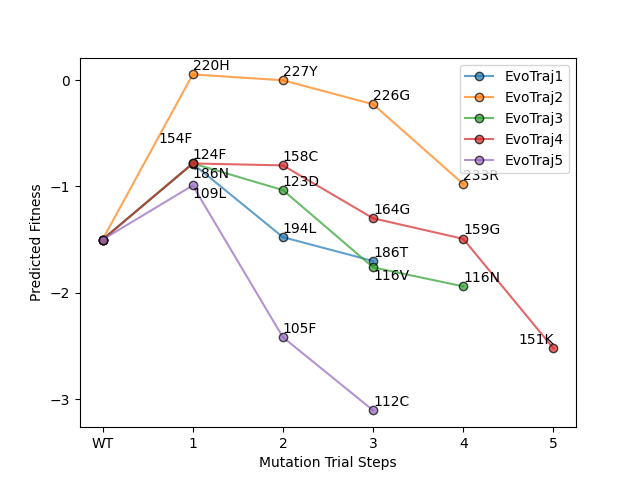

To explore deeper and/or more trajectories, one can change these parameters accordingly:

In [ ]:
%run ../../pypef/main.py ml -e aaidx directevo -m FAUJ880104 -w Sequence_WT_ANEH.fasta -y -1.5 --numiter 10 --numtraj 8 --negative
#%run ../../pypef/main.py ml -e onehot directevo -m ONEHOTMODEL -w Sequence_WT_ANEH.fasta -y -1.5 --numiter 10 --numtraj 8 --negative
#%run ../../pypef/main.py ml -e dca directevo -m DCAMODEL -w Sequence_WT_ANEH.fasta -y -1.5 --numiter 10 --numtraj 8 --negative --params ANEH_72.6.params

To only use the data that is provided in the csv, one can define the flags `--usecsv` for just using the positions that are given in the csv data and additionally `--csvaa` to only use the substitution amino acids that are given in the csv data. 

In [ ]:
%run ../../pypef/main.py ml -e aaidx directevo -m FAUJ880104 -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta -y -1.5 --usecsv --csvaa --negative
#%run ../../pypef/main.py ml -e onehot directevo -m ONEHOTMODEL -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta -y -1.5 --usecsv --csvaa --negative
#%run ../../pypef/main.py ml -e dca directevo -m DCAMODEL -i 37_ANEH_variants.csv -w Sequence_WT_ANEH.fasta -y -1.5 --temp 0.1 --usecsv --csvaa --negative --params ANEH_72.6.params

The effect of FFT is seen for the *in silico* directed evolution drastically, this as as the model without FFT has no variance for the unknown (neighboring) substitution positions. This means that randomly chosing positions (which has very high uncertainty anyways and the recombination of positions and amino acids using `--usecsv` and `--csvaa` will have lower uncertainty) will likely have no effects on estimated substitution effects when using the `--nofft` option (more discussion and plot of impact of substitution on the feature vector is given in the Supporting Information of our paper). E.g., you can see this effect when training a "noFFT" model and subsequently running directed evolution and looking at the trajectory plot.

In [ ]:
%run ../../pypef/main.py ml -e aaidx -l LS.fasl -t TS.fasl --regressor pls --nofft
%run ../../pypef/main.py ml --show
%run ../../pypef/main.py ml -e aaidx directevo -m WEBA780101 -w Sequence_WT_ANEH.fasta -y -1.5 --negative --nofft

For testing model performances for low $N$ and mutational extrapolation tasks, we can encode the variant-fitness CSV file and use the encoded sequences for model training on (differently sized) CSV subsets and predict the left-out variants from the CSV. For AAindex-based encoding the AAindex used for encoding must be specified (`-m`). First, let's encode sequences:

In [ ]:
%run ../../pypef/main.py encode -i 37_ANEH_variants.csv -e aaidx -m FAUJ880104 -w Sequence_WT_ANEH.fasta
#%run ../../pypef/main.py encode -i 37_ANEH_variants.csv -e onehot -w Sequence_WT_ANEH.fasta
#%run ../../pypef/main.py encode -i 37_ANEH_variants.csv -e dca -w Sequence_WT_ANEH.fasta --params ANEH_72.6.params

In [ ]:
%run ../../pypef/main.py ml low_n -i 37_ANEH_variants_aaidx_encoded.csv
#%run ../../pypef/main.py ml low_n -i 37_ANEH_variants_onehot_encoded.csv
#%run ../../pypef/main.py ml low_n -i 37_ANEH_variants_dca_encoded.csv

Finally, you can also test performance for mutational extrapolation learning on single substitutional data (or on concatenated levels of substitutions) and predicting higher substituted variants:

In [ ]:
%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_aaidx_encoded.csv
#%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_onehot_encoded.csv
#%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_dca_encoded.csv

... and on concatenated substitution levels for training:

In [ ]:
%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_aaidx_encoded.csv --conc
#%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_onehot_encoded.csv --conc
#%run ../../pypef/main.py ml extrapolation -i 37_ANEH_variants_dca_encoded.csv --conc

If you like, you can also compare performances to the regression options Ridge, LassoLars, ElasticNet, SVR, RF, MLP, and using the `--nofft` (and/or `--all`) option as well as other types of encodings `-e onehot` (`-e onehot`, `-m ONEHOTMODEL`) or `-e dca` (DCA requires the PLMC parameter file as further input: `-e dca`, `-m DCAMODEL`, `--params PLMC_PARAMETER_FILE`) and hybrid modeling (`pypef hybrid`, commands given below) – and feel free to implement and test other regression and encoding options in your private code repository).

### Hybrid modeling using the MERGE method
Now we exploit deep mutational scanning data using the avGFP dataset for hybrid modeling: in total >50k single to deeply mutated screened variants. Note: Due to the vastness of the protein fitness dataset, running the following part could require several hours. As DCA-based encoding required for hybrid modeling is based on the underlying multiple sequence alignment (MSA) for constructing the coupling and local terms, aligned regions with high gap contents are not considered for deriving evoltionary information of this sequence position such that these positions will not be used for encoding sequences. Hence, DCA-based encoding (with our approach) usually leads to numerical vector representations of the length $\leq L$. Encoding of a huge dataset such as the avGFP dataset might take some time without using multiple threads (which is not possible herein - but when running in terminal).<br> 
**For details of this method implemented, see the [bioRxiv Preprint](https://www.biorxiv.org/content/10.1101/2022.06.07.495081v1).**<br>
Preprocessing of the coupling file was done with:
- WT Sequence taken from https://www.uniprot.org/uniprotkb/P42212/entry and substituted to variant F64L (see [original manuscript SI](https://static-content.springer.com/esm/art%3A10.1038%2Fnature17995/MediaObjects/41586_2016_BFnature17995_MOESM548_ESM.pdf)).
- Running jackhmmer using the WT sequence as query against a sequence database (e.g. from UniProt, https://www.uniprot.org/help/downloads, such as Uniref50, Uniref90, or Uniref100) and setting `--incT` to 0.5*L*, i.e. `--incT 119`:<br>
`jackhmmer --cpu 16 --incT 119 -A uref100_avgfp_jhmmer_119.sto P42212_F64L.fasta /path/to/uniref100_2021_04.fasta`
- Preprocessing and converting the alignment in STO format to A2M format (see output value for the flag `-le` required for the PLMC step):<br> `pypef sto2a2m --sto uref100_avgfp_jhmmer_119.sto --inter_gap 0.3 --intra_gap 0.5` 
- Using the created avgfp_119_jhmmer.a2m MSA file for computing the evolutionary coupling and local terms using [PLMC](https://github.com/debbiemarkslab/plmc):<br>
`plmc -o uref100_avgfp_jhmmer_119_plmc_37.8.params -le 37.8 -m 100 -g -f TARGET_SEQ uref100_avgfp_jhmmer_119.a2m`


With the output PLMC params file we can encode the variant sequences for DCA-based pure ML or hybrid modeling.<br> If you face an error stating a ValueError like `ValueError: Mapping length inconsistent with model length: 0 1936876918` means that you used the Git LFS placeholder file as input (1KB file size) instead of the computed parameter file (~ 71 MB file size; unfortunately no further repository space); either perform the steps for generating the PLMC .params file as described or download the file from https://github.com/niklases/PyPEF/raw/main/workflow/test_dataset_avgfp/uref100_avgfp_jhmmer_119_plmc_42.6.params and replace the 1KB file with this file. The encoded avGFP dataset was generated with (encoding the CSV file for hybrid modeling takes circa 1 h using a single thread):<br>
`pypef encode -e dca -i avGFP.csv -w P42212_F64L.fasta --params uref100_avgfp_jhmmer_119_plmc_37.8.params`
<br>The output is the "encoded" variant CSV file (avGFP_dca_encoded.csv) which we can use for modeling low *N* or mutational extrapolation engineering tasks later on (commands for selecting the other options for encoding:
`pypef encode -e onehot -i avGFP.csv -w P42212_F64L.fasta` and `pypef encode -e aaidx -m MODEL12345 -i avGFP.csv -w P42212_F64L.fasta`, e.g. using the best tested index `-m GEIM800103`).
<br> Changing directory to the avGFP dataset:

In [ ]:
%cd ../test_dataset_avgfp

Encoding the CSV files: **Hybrid/DCA-based sequence encoding requires the generated PLMC parameter file (71 MB) [download](https://github.com/niklases/PyPEF/raw/main/workflow/test_dataset_avgfp/uref100_avgfp_jhmmer_119_plmc_42.6.params)** and saving it to workflow/test_dataset_avgfp/ potentially replacing the uref100_avgfp_jhmmer_119_plmc_37.8.params file (1 KB):

In [ ]:
import urllib.request
from hashlib import sha256
# Single substituted encoded variants: CSV files including variant name and true fitness
url = 'https://github.com/Protein-Engineering-Framework/PyPEF/raw/master/workflow/test_dataset_avgfp/avGFP.csv'
urllib.request.urlretrieve(url, 'avGFP.csv')
with open('avGFP.csv', 'rb') as f:
    sha256_hash = sha256(f.read()).hexdigest()
    if not sha256_hash == 'be4623f35a5ba05d33a29ae6e69dc3c2e994e3c9092cd5880a8d0bbc12f187b1':
        raise SystemError("Hash of downloaded CSV file not correct, terminating further running.")
url = 'https://github.com/niklases/PyPEF/raw/main/workflow/test_dataset_avgfp/uref100_avgfp_jhmmer_119_plmc_42.6.params'
urllib.request.urlretrieve(url, 'uref100_avgfp_jhmmer_119_plmc_42.6.params') # File size: 71.2 MB
with open('uref100_avgfp_jhmmer_119_plmc_42.6.params', 'rb') as f:
    sha256_hash = sha256(f.read()).hexdigest()
    if not sha256_hash == '8baa30bc7d568906d4b587d4c6babd025041bf2f967f303fa38070d2df339830':
        raise SystemError("Hash of downloaded DCA parameter file not correct, terminating further running.")
print('Successfully downloaded all required files!')

In [ ]:
%run ../../pypef/main.py encode -e dca -i avGFP.csv -w P42212_F64L.fasta --params uref100_avgfp_jhmmer_119_plmc_42.6.params
%run ../../pypef/main.py encode -e onehot -i avGFP.csv -w P42212_F64L.fasta
# AAindex encoding, e.g. using AAindex GEIM800103 
%run ../../pypef/main.py encode -e aaidx -m GEIM800103 -i avGFP.csv -w P42212_F64L.fasta

Low *N* engineering task:

In [ ]:
%run ../../pypef/main.py hybrid low_n -i avGFP_dca_encoded.csv
# comparing to pure ML: DCA, onehot, and AAindex model
%run ../../pypef/main.py ml low_n -i avGFP_dca_encoded.csv
%run ../../pypef/main.py ml low_n -i avGFP_onehot_encoded.csv
%run ../../pypef/main.py ml low_n -i avGFP_aaidx_encoded.csv

Mutational extrapolation task:

In [ ]:
%run ../../pypef/main.py hybrid extrapolation -i avGFP_dca_encoded.csv
# comparing to pure ML: DCA, onehot, and AAindex model
%run ../../pypef/main.py ml extrapolation -i avGFP_dca_encoded.csv
%run ../../pypef/main.py ml extrapolation -i avGFP_onehot_encoded.csv
%run ../../pypef/main.py ml extrapolation -i avGFP_aaidx_encoded.csv

Concatenated mutational extrapolation task:

In [ ]:
%run ../../pypef/main.py hybrid extrapolation -i avGFP_dca_encoded.csv --conc
# comparing to pure ML: DCA, onehot, and AAindex model
%run ../../pypef/main.py ml extrapolation -i avGFP_dca_encoded.csv --conc
%run ../../pypef/main.py ml extrapolation -i avGFP_onehot_encoded.csv --conc
%run ../../pypef/main.py ml extrapolation -i avGFP_aaidx_encoded.csv --conc

You can now compare the different performances of encodings for this tasks (see saved PNG plots).

#### Done! End of Notebook.